In [41]:
%reset -f
import glob, os, sys, inspect
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import pandas as pd
from wavhandler import *
from natsort import natsorted
from utils import *
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import io
import PIL
import seaborn as sns; sns.set()

np.random.seed(0)
plt.rcParams['figure.figsize'] = [24, 8]

import logging
logger = logging.getLogger()
logger.setLevel(logging.WARN)

# Example Raw Signal

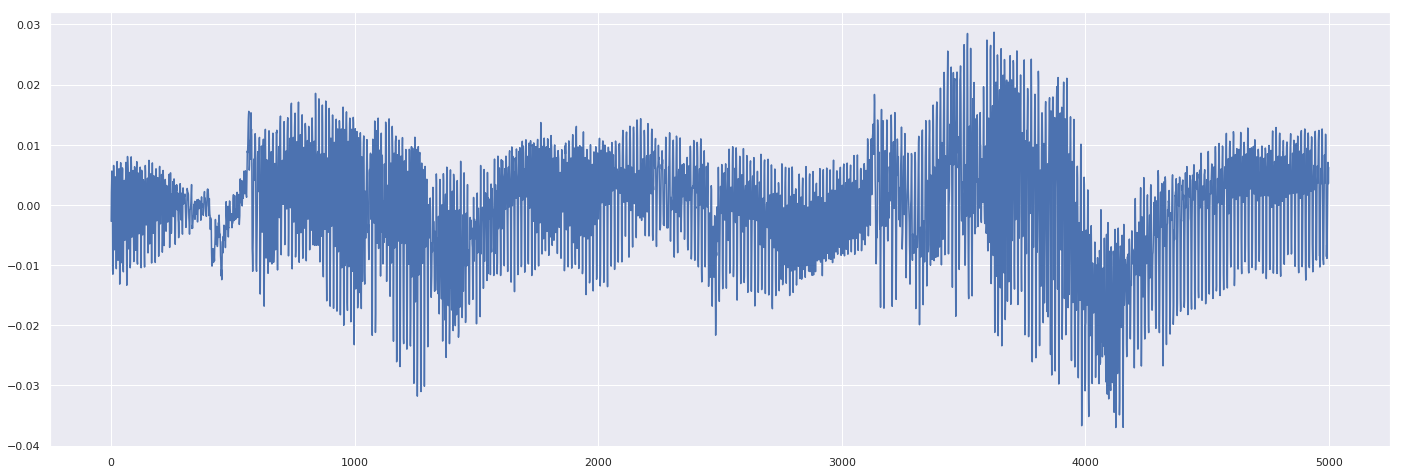

In [42]:
smpl = 1
z = WavHandler('/home/yannis/data/insects/Potamitis/Wingbeats/Aedes', sample_size=smpl, recursive=True)
z.read()
z.df_signals.iloc[:,0].plot()

# Signal after applying [75,1000] bandpass filter

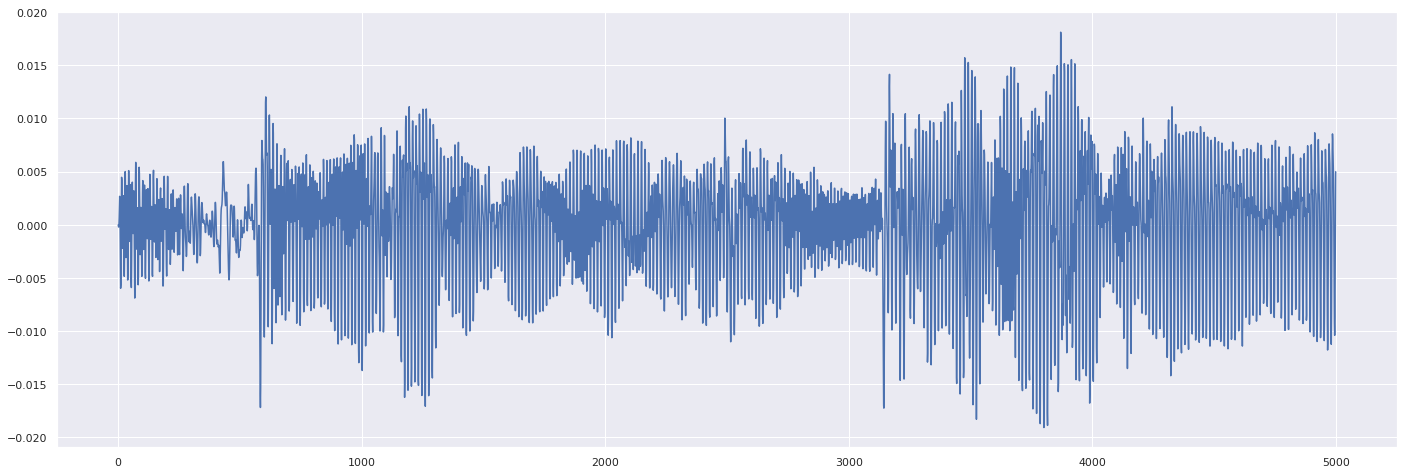

In [43]:
z.preprocess()
#z.filter_accepted_signals()
#print(len(z.accepted_signals))
z.df_signals.iloc[:,0].plot()

# Power Spectral Density (Welch's, Hamming window)

peakseries: 
 0    2.519925e-07
1    1.065907e-07
Name: pows, dtype: float64
[ 562.5  1093.75]

IS THIS SIGNAL ACCEPTED? ----> True


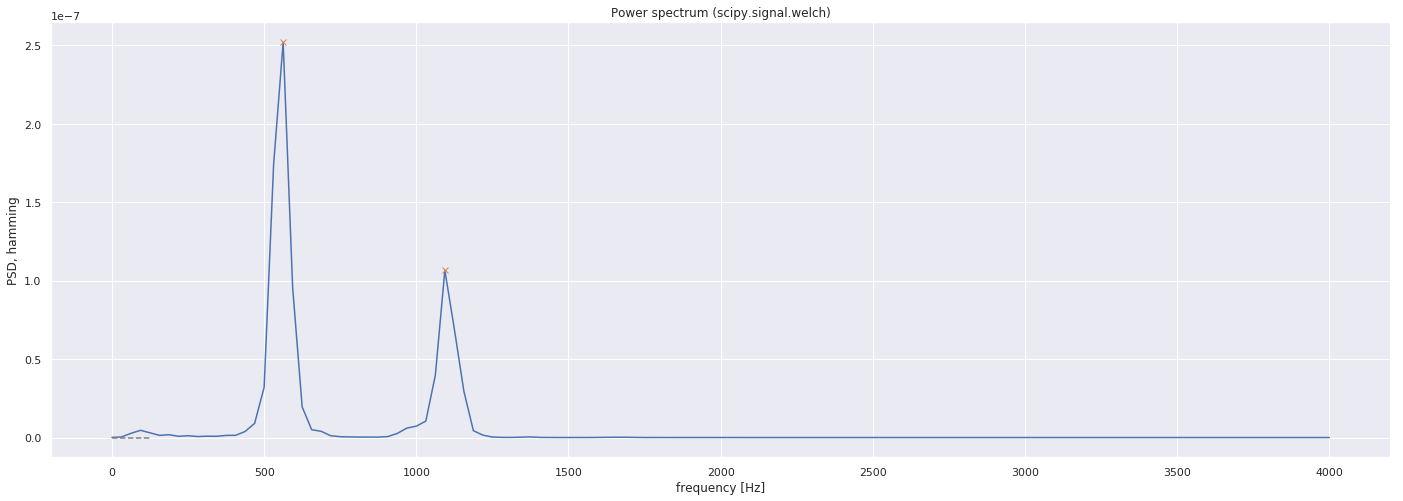

In [44]:
sig = z.df_signals.iloc[:,0]
from scipy.signal import find_peaks
f, Pxx = signal.welch(sig, 8000., scaling='density', window='hamming')
x = Pxx
threshold = 0.000000025
peaks, vals = find_peaks(x, height=threshold, distance=10)
peaks = [v for i,v in enumerate(peaks) if f[peaks][i] > 300]
plt.plot(f,Pxx);plt.plot(f[peaks], x[peaks], "x");plt.plot(np.zeros_like(x), "--", color="gray")
plt.xlabel('frequency [Hz]');plt.ylabel('PSD, hamming');plt.title('Power spectrum (scipy.signal.welch)')

df = pd.DataFrame(np.vstack((f[peaks], x[peaks])).T, columns=['freqs','pows'])
peakseries = df[df.freqs>400]['pows'].nlargest(5)
print('peakseries: \n',peakseries)
if peakseries.shape[0] == 2:
    # If there are 2 peaks, return True only if
    # the highest peak is larger than the threshold OR
    # the second highest peak is larger than the threshold
    condition = (peakseries.iloc[0] > threshold or peakseries.iloc[1] > threshold)
elif peakseries.shape[0] > 2:
    # If there are more peaks, return True if
    # the same as above AND
    # the leftmost peak is higher than the third peak (counting from the left) AND
    # the second peak from the left is also higher than the third peak
    condition = (peakseries.iloc[0] > threshold or peakseries.iloc[1] > threshold) and \
            (peakseries.loc[0] > peakseries.loc[2]) and \
            (peakseries.loc[1] > peakseries.loc[2])
else:
    condition = False
print(f[peaks])
print("\nIS THIS SIGNAL ACCEPTED? ----> {}".format(condition))

# Signal Cropping

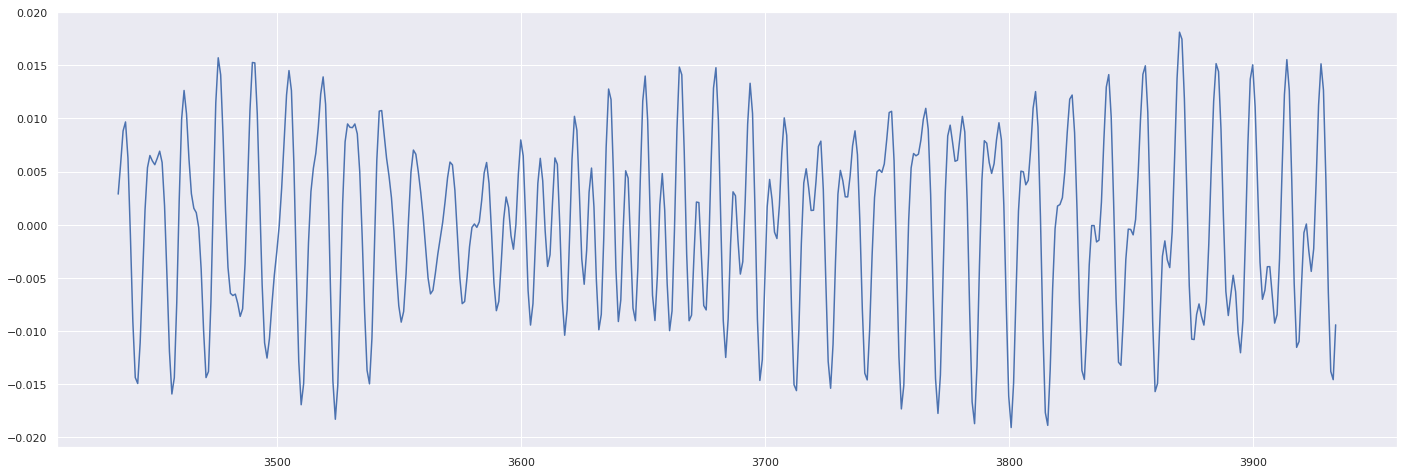

In [45]:

sigseries = pd.Series(sig)
window = 500
rolling_mean = np.abs(sigseries).rolling(window).mean()
sigseries.iloc[rolling_mean.idxmax()+1-window:rolling_mean.idxmax()+1].plot()

# Spectrogram

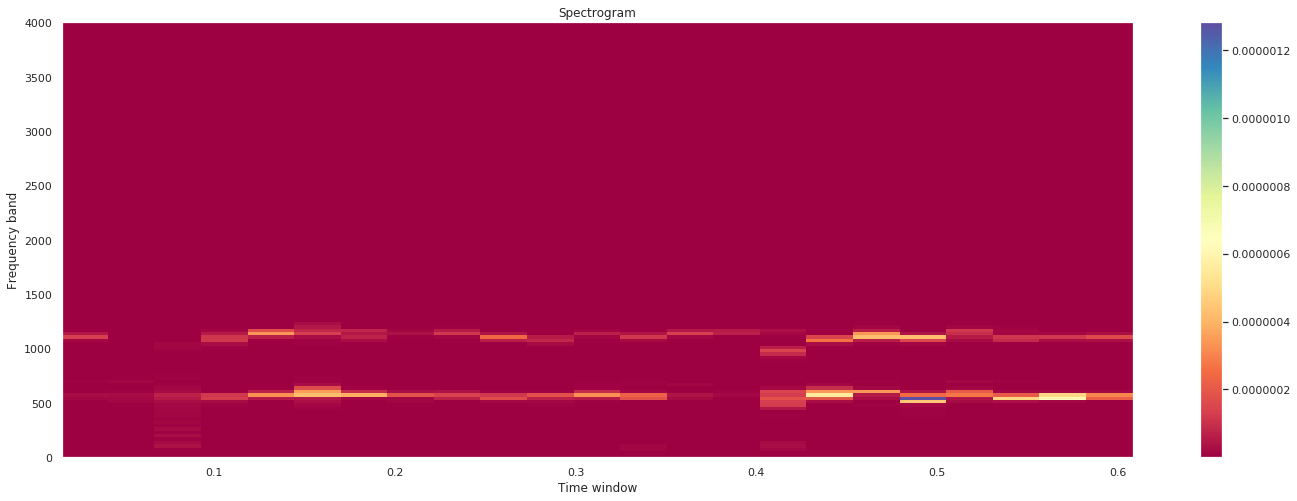

In [57]:
freqs, times, spectrogram = signal.spectrogram(sig, 8000., noverlap=50,window='hamming')
plt.title('Spectrogram')
plt.ylabel('Frequency band')
plt.xlabel('Time window')
#plt.imshow(spectrogram, aspect='auto', cmap='hot_r', origin='lower')

plt.pcolormesh(times, freqs, spectrogram, cmap='Spectral')
plt.colorbar()

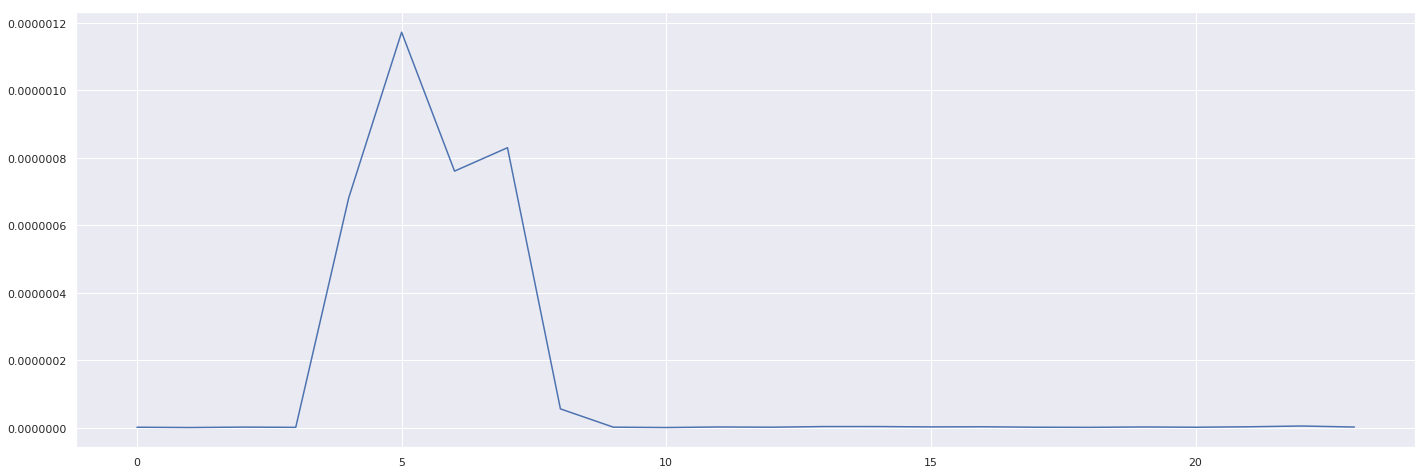

In [21]:
plt.plot(spectrogram.sum(axis=0))#, keepdims=True))


In [22]:
times, times.shape


(array([0.016  , 0.04175, 0.0675 , 0.09325, 0.119  , 0.14475, 0.1705 ,
        0.19625, 0.222  , 0.24775, 0.2735 , 0.29925, 0.325  , 0.35075,
        0.3765 , 0.40225, 0.428  , 0.45375, 0.4795 , 0.50525, 0.531  ,
        0.55675, 0.5825 , 0.60825]), (24,))

In [23]:
freqs,freqs.shape

(array([   0.  ,   31.25,   62.5 ,   93.75,  125.  ,  156.25,  187.5 ,
         218.75,  250.  ,  281.25,  312.5 ,  343.75,  375.  ,  406.25,
         437.5 ,  468.75,  500.  ,  531.25,  562.5 ,  593.75,  625.  ,
         656.25,  687.5 ,  718.75,  750.  ,  781.25,  812.5 ,  843.75,
         875.  ,  906.25,  937.5 ,  968.75, 1000.  , 1031.25, 1062.5 ,
        1093.75, 1125.  , 1156.25, 1187.5 , 1218.75, 1250.  , 1281.25,
        1312.5 , 1343.75, 1375.  , 1406.25, 1437.5 , 1468.75, 1500.  ,
        1531.25, 1562.5 , 1593.75, 1625.  , 1656.25, 1687.5 , 1718.75,
        1750.  , 1781.25, 1812.5 , 1843.75, 1875.  , 1906.25, 1937.5 ,
        1968.75, 2000.  , 2031.25, 2062.5 , 2093.75, 2125.  , 2156.25,
        2187.5 , 2218.75, 2250.  , 2281.25, 2312.5 , 2343.75, 2375.  ,
        2406.25, 2437.5 , 2468.75, 2500.  , 2531.25, 2562.5 , 2593.75,
        2625.  , 2656.25, 2687.5 , 2718.75, 2750.  , 2781.25, 2812.5 ,
        2843.75, 2875.  , 2906.25, 2937.5 , 2968.75, 3000.  , 3031.25,
      

In [24]:
spectrogram

array([[4.24791089e-14, 6.42753056e-13, 2.54597465e-12, ...,
        2.69818675e-12, 3.14410483e-14, 1.40748496e-19],
       [1.18031519e-12, 8.98342906e-13, 1.43072751e-12, ...,
        3.69986046e-13, 1.64633856e-12, 8.57397343e-13],
       [7.60032841e-11, 3.18142262e-12, 4.18770461e-11, ...,
        7.52162044e-11, 1.78561009e-11, 2.08336118e-11],
       ...,
       [4.68188482e-17, 3.98140216e-15, 9.50911532e-16, ...,
        9.95442287e-16, 7.61413447e-18, 3.22608753e-17],
       [4.67887629e-17, 3.97936470e-15, 9.50396501e-16, ...,
        9.94866615e-16, 7.52562833e-18, 3.22248476e-17],
       [2.33893704e-17, 1.98934293e-15, 4.75112456e-16, ...,
        4.97337416e-16, 3.74807856e-18, 1.61064241e-17]])

In [25]:
spectrogram.shape

(129, 24)